# Principal Component Analysis of Nowcast Velocities
This notebook describes the process of performing complex principal component analysis (C-PCA) on the SalishSeaCast Nowcast velocity record and explores the results.

This notebook is organized into the following sections:

   1. [Load Nowcast and GEM Record](#Load-Nowcast-and-GEM-Record)
   2. [Principal Component Analysis](#Principal-Component-Analysis)
   3. [Varimax Rotation](#Varimax-Rotation)
   4. [Explore Results](#2016-HRDPS-Wind-EOFs)

In [478]:
from salishsea_tools import grid_tools, nc_tools, timeseries_tools, viz_tools
from mpl_toolkits.basemap import Basemap
from matplotlib import gridspec, patches, dates
from dateutil import parser
import timeseries_extras
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

## Load Nowcast and GEM Record
Load grid and mask files.

In [224]:
# Load mask and grid
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask_downbyone2.nc')
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathy_downonegrid2.nc', mask_and_scale=False)
grid_GEM = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m01d01.nc')

Build GEM mask

In [3]:
# Build GEM mask
mask_GEM = grid_tools.build_GEM_mask(grid_GEM, grid, mask.tmask.isel(t=0, z=0))

Building GEM mask 100% (68096 of 68096) |###################################|Time: 0:04:09


Load Nowcast record

In [ ]:
# Load Nowcast
with open('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/testdata', 'w') as fid:
    Nowcast = pickle.load(fid)

Specify time range (must match `Nowcast[var][dim][index]['coords']['timerange']`)

In [4]:
# Timerange
timerange = ['2016 Jan 1 00:00', '2017 Jan 1 00:00']

Load GEM record from ERDDAP

In [5]:
# Load GEM record
GEM_in = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
GEM_flat = timeseries_extras.reshape_GEM(GEM_in.sel(time=slice(*timerange)), grid_GEM, mask_GEM)

Filter tides.

In [ ]:
# Filter tides 
variables = ['vozocrtx', 'vomecrty']  # Just the velocities
dims = ['depth']  # Just the horizontal currents
for variable in variables:
    for dim in dims:
        for section in Nowcast[variable][dim].items():
            section[1]['filter'] = tidetools.filter_timeseries(section[1]['data'], method='doodson')

# Filter wind
GEM_flat['filter']['grid']['u'] = tidetools.filter_timeseries(GEM_flat['raw']['grid']['u'], method='doodson')
GEM_flat['filter']['grid']['v'] = tidetools.filter_timeseries(GEM_flat['raw']['grid']['v'], method='doodson')

Rotate velocities.

In [ ]:
# Rotate U wind
GEM_flat['raw']['rotate']['u'], GEM_flat['raw']['rotate']['v'] = viz_tools.rotate_vel(
    GEM_flat['raw']['grid']['u'], GEM_flat['raw']['grid']['v'], origin='map')

# Rotate V wind
GEM_flat['filter']['rotate']['u'], GEM_flat['filter']['rotate']['v'] = viz_tools.rotate_vel(
    GEM_flat['filter']['grid']['u'], GEM_flat['filter']['grid']['v'], origin='map')

Spatially averaged the alongstrait wind component.

In [ ]:
# Spatially average the alongstrait wind component
wind_index = GEM_flat['raw']['rotate']['v'].mean(axis=1)
wind_index_filter = GEM_flat['filter']['rotate']['v'].mean(axis=1)

## Principal Component Analysis

### Complex Principal Component Analysis

from Preisendorfer and Mobley 1988, *Principal Component Analysis in Meteorology and Oceanography*<br /><br />

Let $\mathbf{X}$ and $\mathbf{Y}$ be real-valued $n \times p$ ($p \le n$) matrices containing $n$ respective $u$ and $v$ velocity anomaly observations at $p$ locations.

In [ ]:
# Find the currents anomaly
X = Nowcast['vozocrtx']['depth'][0]['filter'] - Nowcast['vozocrtx']['depth'][0]['filter'].mean(axis=0)[np.newaxis, :]
Y = Nowcast['vomecrty']['depth'][0]['filter'] - Nowcast['vomecrty']['depth'][0]['filter'].mean(axis=0)[np.newaxis, :]

Let $\mathbf{Z}$ be a complex $n \times p$ matrix of rank $m$ ($m \le p$)

$$\mathbf{Z} = \mathbf{X} + i\mathbf{Y}$$

In [ ]:
# Make the complex matrix
Z = X + 1j * Y

The PCA synthesis formula for $\mathbf{Z}$ is

$$\mathbf{Z} = \mathbf{A}\mathbf{E}^\mathrm{T} \tag{Eq 2.155}$$

where $\mathbf{A}$ and $\mathbf{E}$ have the following significance.

   * $\mathbf{A}$ is the $n \times m$ principal component (PC) matrix whose columns are the $m$ PCs of the $m$ orthogonal modes of variability.
   
   * $\mathbf{E}$ is the $p \times m$ empirical orthogonal function (EOF) matrix whose columns are the $m$ EOFs of the $m$ orthogonal modes of variability.

There are two primary ways to obtain $\mathbf{A}$ and $\mathbf{E}$.

**1. Eigendecomposition**

Eigendecomposition the $p \times p$ scatter matrix $\mathbf{S}$

$$\mathbf{S} = \mathbf{Z}^\mathrm{T}\mathbf{Z}^*  \tag{Eq 2.133}$$

produces the $p \times m$ eigenvector matrix $\mathbf{E}$ and the $m \times m$ diagonal eigenvalue matrix $\mathbf{L}$

$$\mathbf{S} = \mathbf{E}\mathbf{L}\mathbf{E}^\dagger \tag{Eq 2.149}$$

where $*$ denotes the complex conjugate and $\dagger$ denotes the complex conjugate transpose.

In [ ]:
# Eigendecomposition
L, E = np.linalg.eig(Z.T.dot(Z.conj()))

The PC scores $\mathbf{A}$ can thus be obtained from $\mathbf{E}$ and $\mathbf{Z}$ using the PCA analysis formula

$$\mathbf{A} = \mathbf{Z}\mathbf{E}^\mathrm{*} \tag{Eq 2.154}$$

In [ ]:
# PCA Analysis Formula
A = Z.dot(E.conj())

**2. Singular Value Decomposition**

Singular value decomposition (SVD) can be applied directly to $\mathbf{Z}$ and thus bypasses the scatter matrix $\mathbf{S}$

$$\mathbf{Z} = \mathbf{A}'\mathbf{L}^{1/2}\mathbf{E}^\mathrm{T} \tag{Eq 2.108}$$

In [ ]:
# Singular value decomposition
A_prime, sqrtL, E_T = np.linalg.svd(Z, full_matrices=False)

From Eq 2.155 and Eq 2.108, $\mathbf{A}$ is simply the product of $\mathbf{A}'$ and $\mathbf{L}^{1/2}$

In [ ]:
# A from SVD and synthesis formula
A = A_prime.dot(np.diag(sqrtL))

**Percent Variance**

Since the eigenvalue matrix $\mathbf{L}$ represents the scatter (or variance) of $\mathbf{Z}$ along $\mathbf{E}$ (Eq 2.101), the variance fraction explained by the $j$th mode is given by

$$\frac{l_{j}}{\sum_{j=1}^{m}l_{j}}$$

In [ ]:
# Extract explained variance
PercentVar = sqrtL**2/(sqrtL**2).sum()

**Predicted Fields**

Given $\mathbf{A}$ and $\mathbf{E}$, a $j$th mode prediction for $\mathbf{Z}$ can be obtained based on the synthesis formula Eq 2.155

$$\mathbf{Z}_{j} = \mathbf{a}_{j}\mathbf{e}_{j}^\mathrm{T}$$

or for the subset of $k$ modes $q = [q_1, ..., q_k]$

$$\mathbf{Z}_{q} = \sum_{j=q_1}^{q_k}\mathbf{a}_{j}\mathbf{e}_{j}^\mathrm{T}$$

In [ ]:
# Reconstruct mode 1 fields
Z_0 = A[:, 0, np.newaxis].dot(E_T[0, np.newaxis, :])

### Varimax Rotation

From the PCA synthesis formula (Eq 2.155)

$$\mathbf{Z} = \mathbf{A}\mathbf{E}^\mathrm{T}$$

introduce a rotation matrix $\mathbf{R}$ such that

$$\mathbf{Z} = \mathbf{A}(\mathbf{R}\mathbf{R}^\mathrm{T})\mathbf{E}^\mathrm{T} = (\mathbf{A}\mathbf{R})(\mathbf{E}\mathbf{R})^\mathrm{T} = \mathbf{B}\mathbf{U}^\mathrm{T} \tag{Eq 7.6}$$

where $\mathbf{B}$ is the rotated PC matrix and $\mathbf{U}$ is the rotated EOF matrix. By the orthonormality of $\mathbf{U}$

$$\mathbf{B} = \mathbf{Z}\mathbf{U}^* \tag{Eq 7.6}$$

or

$$b_j(t) = \mathbf{z}(t)\mathbf{u}_j^* \tag{Eq 7.12}$$

where $b_j(t)$ are the rotated PCs of the $j$ modes for the $t$ observations. When clusters of $\mathbf{z}(t)$ observations align closely to the rotated EOFs $\mathbf{u}_j$, $b_j(t)$ tends toward a maximum while $b_{j+1}(t)$ tends toward a minimum because of EOF orthogonality. The varimax technique thus seeks a rotation that maximizes the variance of the squares of these rotated PCs, or the quantity below

$$x = \sum_{j=1}^{m}\sum_{t=1}^{n}\left[b_j(t)b_j(t)^* - b_j^2\right]^2 \tag{Eq. 7.14}$$

where $b_j^2$ is the variance of $\mathbf{b}_j$

$$b_j^2 = \frac{1}{n}\sum_{t=1}^{n}b_j(t)b_j(t)^* \tag{Eq. 7.13}$$

In terms of (Eq 7.12)

$$x = \sum_{j=1}^{m}\sum_{t=1}^{n}\left[\mathbf{u}_j^\mathrm{T}\left(\mathbf{z}(t)\mathbf{z}^\dagger(t) - \frac{1}{n}\mathbf{S}\right)\mathbf{u}_j^*\right]^2 \tag{Eq. 7.14}$$

where $\mathbf{S}$ is the $p \times p$ scatter matrix from Eq. 2.133.

Determining the frame $\mathbf{U}$ rotated from $\mathbf{E}$ that maximizes $x$ subject to the orthonormality constraint

$$\mathbf{u}_i^\mathrm{T}\mathbf{u}_j^* = \delta_{ij}, \quad i, j = 1,\dotsc,m \tag{Eq. 7.15}$$

amounts to solving the Lagrangian expression

$$y = x - 2\sum_{r=1}^m\sum_{s=1}^mg_{rs}\left(\mathbf{u}_r^\mathrm{T}\mathbf{u}_s^* - \delta_{rs}\right) \tag{Eq. 7.16}$$

where $g_{rs}$ are Lagrange multipliers and $\delta_{rs}$ is Kronecker's delta. Substituting Eq 7.14 and setting $\partial y/\partial\mathbf{u}=0$, the Lagrangian expression produces the following relation in matrix form

$$\mathbf{V} = \mathbf{U}\mathbf{G} \tag{Eq. 7.17}$$

where

$$\mathbf{V} = \mathbf{Z}^\mathrm{T}\left(\mathbf{B}^{(3)} - \frac{1}{n}\mathbf{B}\mathrm{diag}\left[\mathbf{B}^\mathrm{T}\mathbf{B}\right]\right) \tag{Eq. 7.18}$$

and $\mathbf{G}$ is the $m \times m$ symmetric matrix of Lagrangian multipliers $g_{rs}$. Since $\mathbf{U}$ is orthogonal and $\mathbf{G}$ is symmetric

$$\mathbf{G}^2 = \mathbf{V}^\mathrm{T}\mathbf{V} = \mathbf{W}^\mathrm{T}\mathbf{K}\mathbf{W} \tag{Eq. 7.24-7.25}$$

where $\mathbf{W}^\mathrm{T}\mathbf{K}\mathbf{W}$ is the eigendecomposition of $\mathbf{V}^\mathrm{T}\mathbf{V}$. It follows that

$$\mathbf{G}^{-1} = \mathbf{W}^\mathrm{T}\mathbf{K}^{-1/2}\mathbf{W} \tag{Eq. 7.26}$$

and from Eq. 7.17

$$\mathbf{U} = \mathbf{V}\mathbf{G}^{-1} \tag{Eq. 7.22}$$

Thus $\mathbf{U}$ can be obtained iteratively using an initial guess (for instance, $\mathbf{E}$). Horst (1965, *Factor Analysis of Data Matrices*) recommends either $\mathrm{trace}\left[\mathbf{B}^\mathrm{T}\mathbf{B}\right]$ or $\mathrm{trace}\left[\mathbf{V}^\mathrm{T}\mathbf{V}\right]$ as convergence criteria.

In [ ]:
def varimax(E, Z, maxiter=20, tol=1e-6):
    """Varimax routine from Preisendorfer and Mobley 1988 pages 274-276
    """
    
    # Initialize U with E
    U = E
    d = 0
    
    # Iterate to find U (Eq 7.22)
    for i in xrange(maxiter):
        d_old = d
        B = Z.dot(U)  # --------------------------- Eq 7.8
        C = B**3  # ------------------------------- Eq 7.19
        D = np.diag(np.diag(B.T.dot(B)))  # ------- Eq 7.20
        V = Z.T.dot(C - B.dot(D))  # -------------- Eq 7.18
        K, W = np.linalg.eig(V.T.dot(V))  # ------- Eq 7.25
        G = W.dot(np.diag(K**(-1/2)).dot(W.T))  # - Eq 7.26
        U = V.dot(G)  # --------------------------- Eq 7.21
        
        # Convergence criteria from Ben FrantzDale
        # https://en.wikipedia.org/wiki/Talk:Varimax_rotation
        d = sum(K)
        if d_old != 0 and d / d_old < 1 + tol:
            break
    
    # Return R (Eq 7.7)
    return E.T.dot(U)

## 2016 HRDPS Wind EOFs
Here I calculate the dominant EOF modes for the 2016 HRDPS record.
### Code section
Boilerplate map projection and model coastline

In [249]:
def make_map(ax, grid, w_map=[-124, -123.9, 47.7, 50.6], rotation=39.2):
    """
    """

    # Make projection
    m = Basemap(ax=ax, projection='lcc', resolution='c',
                lon_0=(w_map[1] - w_map[0]) / 2 + w_map[0] + rotation,
                lat_0=(w_map[3] - w_map[2]) / 2 + w_map[2],
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3])

    # Add features and labels
    x, y = m(grid.nav_lon.values, grid.nav_lat.values)
    ax.contourf(x, y, grid.Bathymetry, [-0.01, 0.01], colors='burlywood')
    ax.contour(x, y, grid.Bathymetry, [-0.01, 0.01], colors='black')
    m.drawmeridians(np.arange(-125.5, -122, 0.5), labels=[0, 0, 0, 1])
    m.drawparallels(np.arange(48, 51, 0.5), labels=[1, 0, 0, 0])
    
    return m

EOF plotting code

In [457]:
def plot_EOF(time, lon, lat, mask, PC, U, V, percentvar, xlims, index):
    """
    """
    
    # Make figure and axes handles
    fig = plt.figure(figsize=(17, 22))
    gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 3, 1, 3])
    axs = [fig.add_subplot(gs[row, :]) for row in [0, 1, 3]]
    axs.extend([fig.add_subplot(gs[2, col]) for col in range(4)])
    axs.extend([fig.add_subplot(gs[4, col]) for col in range(4)])

    # Shade zoomed regions
    for xlim in xlims[1:]:
        parsed = [dates.date2num(parser.parse(date)) for date in xlim]
        axs[0].add_patch(patches.Rectangle((parsed[0], 0), np.diff(parsed), 360, facecolor='lightgray', edgecolor='k'))

    # Plot PC 1 full and zoom
    titles = [
        f'PC Mode 1: Percent Variance = {percentvar:0.2f}',
        f'{xlims[1][0]} to {xlims[1][1]}',
        f'{xlims[2][0]} to {xlims[2][1]}',
    ]
    for ax, xlim, title in zip(axs[:3], xlims, titles):
        ax.plot(time, PC.T)
        ax.set_xlim(xlim)
        ax.set_ylim(0, 360)
        ax.set_ylabel('deg (from) CW from N')
        ax.set_title(title)
        ax.plot(xlim, [330, 330], 'k--')
        ax.plot(xlim, [120, 120], 'k--')

    # Plot on PC timeseries
    for row, ind in zip([1, 1, 1, 1, 2, 2, 2, 2], index):
        axs[row].plot([time[ind], time[ind]], [0, 360], 'r-')

    # Plot spatial fields
    for ax, ind in zip(axs[3:], index):
        m = make_map(ax, grid)
        x, y = m(lon[::4, ::4]-360, lat[::4, ::4])
        Q = ax.quiver(x, y,
            np.ma.masked_where(mask[::4, ::4]==0, U[ind, ::4, ::4]),
            np.ma.masked_where(mask[::4, ::4]==0, V[ind, ::4, ::4]),
            scale=60, width=0.005, headwidth=4)
        ax.text(0, 1.01, pd.to_datetime(time[ind]).strftime('%Y %b %d %H:%M'), transform=ax.transAxes)
        ax.add_patch(patches.Rectangle(
            (0.8, 0.9), 0.19, 0.09, facecolor='w', edgecolor='k',
            transform=ax.transAxes, zorder=5,
        ))
        Q_key = plt.quiverkey(Q, 0.9, 0.93, 5, '5 m/s')
        Q_key.set_zorder(6)

Calculate EOFs

In [74]:
# Wind anomalies
u_wind = GEM_flat['raw']['grid']['u'] - GEM_flat['raw']['grid']['u'].mean(axis=0)[np.newaxis, :]
v_wind = GEM_flat['raw']['grid']['v'] - GEM_flat['raw']['grid']['v'].mean(axis=0)[np.newaxis, :]

# Complex vector
Z = u_wind + 1j * v_wind

# SVD
A_prime, sqrtL, E_T = np.linalg.svd(Z, full_matrices=False)
A = A_prime.dot(np.diag(sqrtL))

# PC's and percent var
PC = 270 - np.angle(A, deg=True)
PC[PC > 360] = PC[PC > 360] - 360
PercentVar = sqrtL**2/(sqrtL**2).sum()

# EOF Mode 1
Z_0 = A[:, 0, np.newaxis].dot(E_T[0, np.newaxis, :])

# EOF Mode 2
Z_1 = A[:, 1, np.newaxis].dot(E_T[1, np.newaxis, :])

# Reshape Modes
shape = GEM_in.gridY.shape + GEM_in.gridX.shape
gridX = (GEM_flat['coords']['gridX']/2500).astype(int)
gridY = (GEM_flat['coords']['gridY']/2500).astype(int)

U_0 = timeseries_tools.reshape_to_grid(Z_0.real, [gridY, gridX], shape)
V_0 = timeseries_tools.reshape_to_grid(Z_0.imag, [gridY, gridX], shape)

U_1 = timeseries_tools.reshape_to_grid(Z_1.real, [gridY, gridX], shape)
V_1 = timeseries_tools.reshape_to_grid(Z_1.imag, [gridY, gridX], shape)

### Plots Section
#### Plot PC Mode 1
This mode summarizes 62% of the variance. It is characterized by essentially uniform wind direction, SE (upstrait) wind during winter and NW (downstrait) wind during summer. Reversals are frequent, especially in winter, and are achieved by rotation. This mode likely accounts for most of the extratropical cyclone activity that dominates the winter wind patterns.
   * PCs are plotted as dominant wind direction (from) in degrees CW from north
   * The gray section in the PC timeseries indicates the zoomed sections in the lower timeseries plots
   * The red lines indicate the dates for each of the 4 spatial first-mode EOF patterns accompanying each zoomed PC record

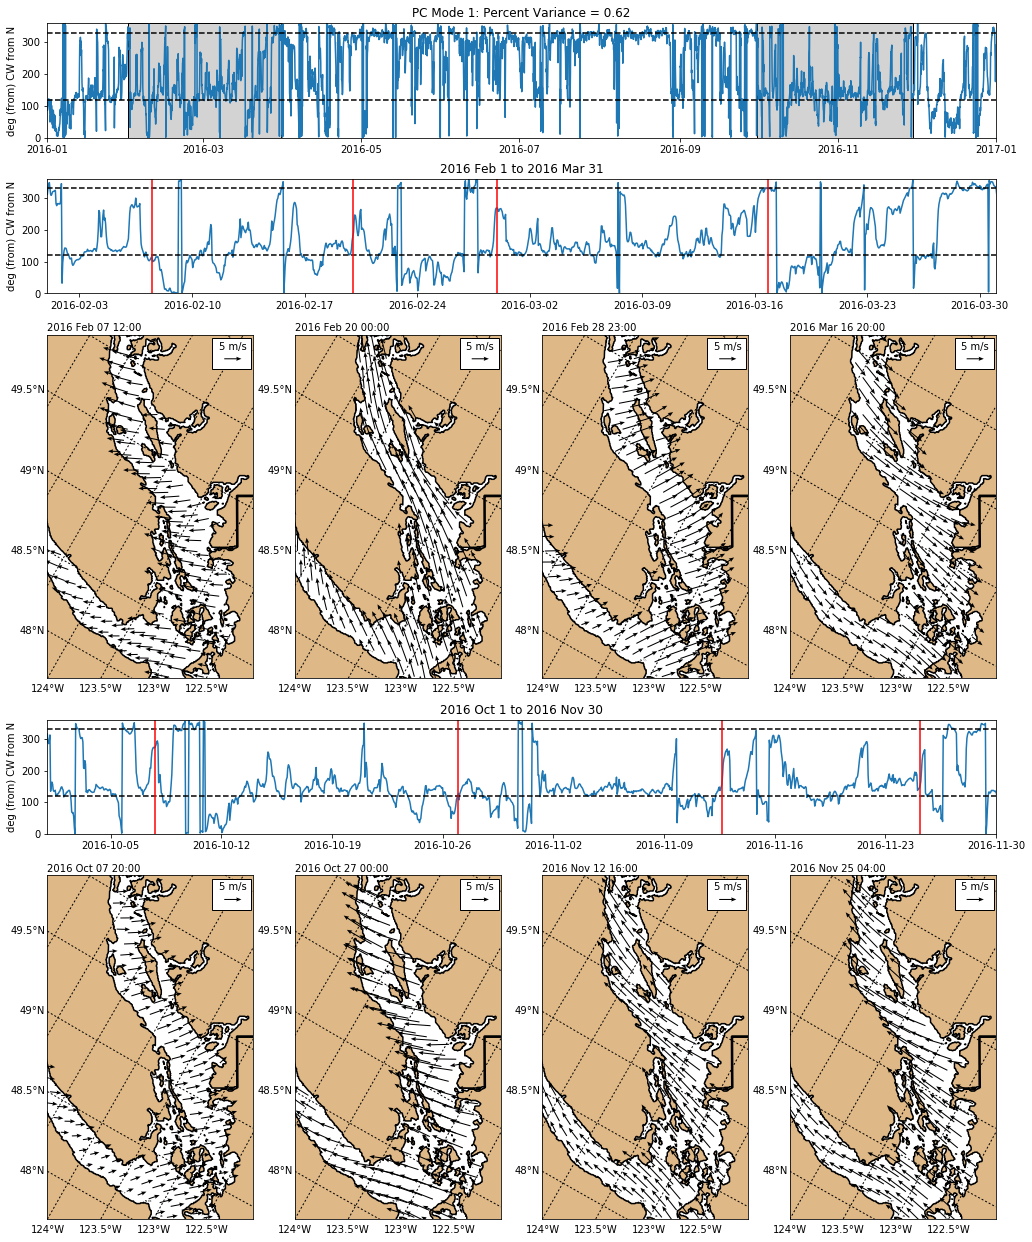

In [459]:
# Date ranges of zoomed regions
xlims = [
    ['2016 Jan 1', '2017 Jan 1'],
    ['2016 Feb 1', '2016 Mar 31'],
    ['2016 Oct 1', '2016 Nov 30'],
]

# Dates to plot spatial patterns
index = [900, 1200, 1415, 1820, 6740, 7200, 7600, 7900]

# Plot EOFs
plot_EOF(
    GEM_in.sel(time=slice(*timerange)).time.values, grid_GEM.nav_lon.values, grid_GEM.nav_lat.values,
    mask_GEM, PC[:, 0], U_0, V_0, PercentVar[0], xlims, index,
)

### Plots Section
#### Plot PC Mode 2
This mode only summarizes 14% of the variance, but the spatial structure is much more heterogeneous than mode 1. Spring patterns tend to oscillate between a mesoscale cyclonic and anticyclonic circulation centred over the gulf islands. During summer, these patterns are still present, but may also include the effects of seabreezes. This mode should be explored in greater detail, and after varimax rotation, this mode may summarize a great deal more variance.
   * PCs are plotted as dominant wind direction (from) in degrees CW from north
   * The gray section in the PC timeseries indicates the zoomed sections in the lower timeseries plots
   * The red lines indicate the dates for each of the 4 spatial first-mode EOF patterns accompanying each zoomed PC record

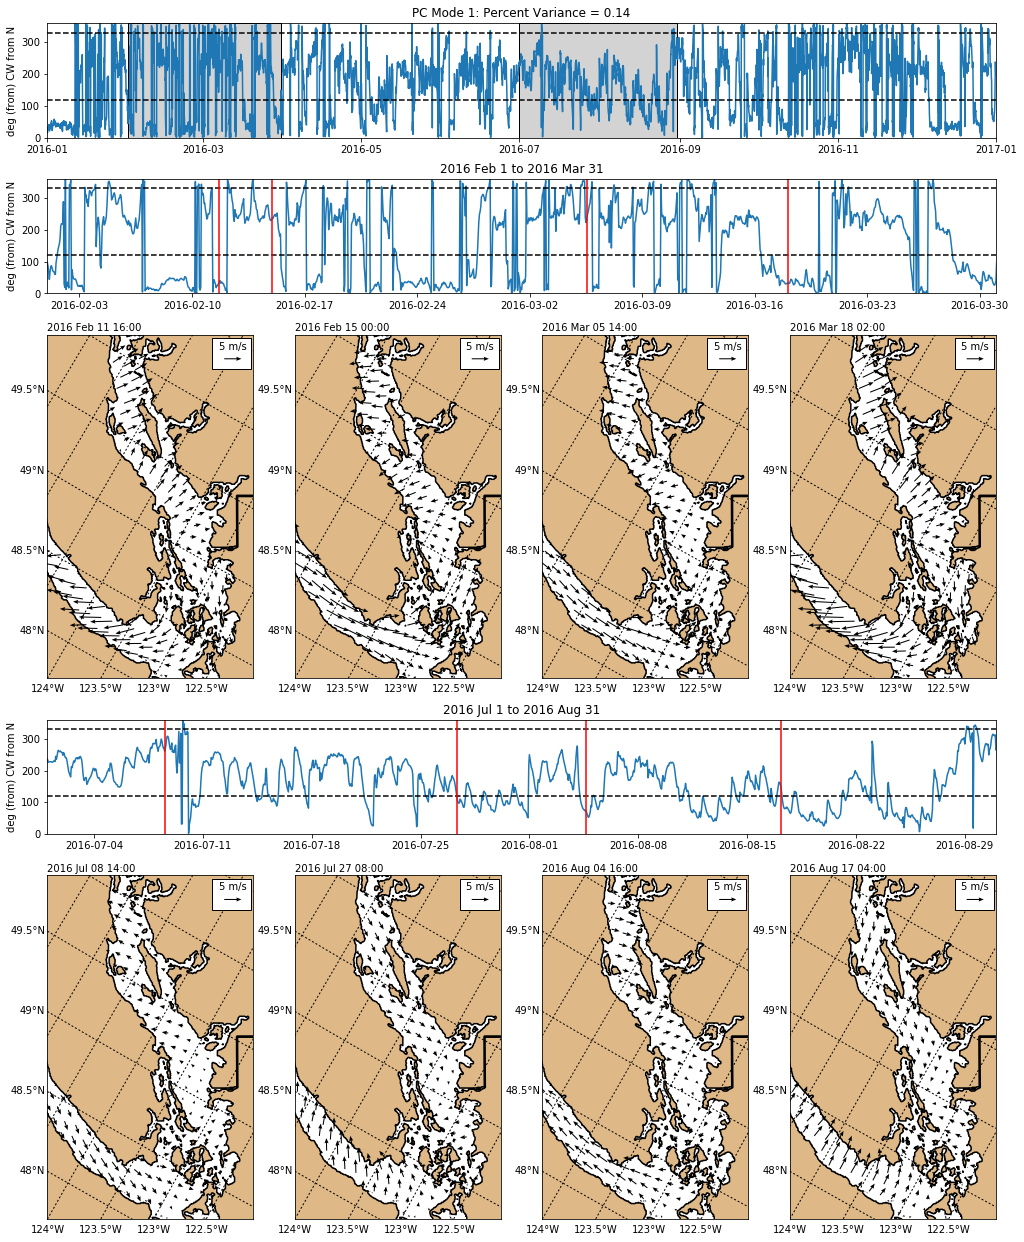

In [474]:
# Date ranges of zoomed regions
xlims = [
    ['2016 Jan 1', '2017 Jan 1'],
    ['2016 Feb 1', '2016 Mar 31'],
    ['2016 Jul 1', '2016 Aug 31'],
]

# Dates to plot spatial patterns
index = [1000, 1080, 1550, 1850, 4550, 5000, 5200, 5500]

# Plot EOFs
plot_EOF(
    GEM_in.sel(time=slice(*timerange)).time.values, grid_GEM.nav_lon.values, grid_GEM.nav_lat.values,
    mask_GEM, PC[:, 1], U_1, V_1, PercentVar[1], xlims, index,
)